In [8]:

import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score

# %config InlineBackend.figure_formats = ['svg']
# %matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sqlalchemy import create_engine
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import pylab
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import itertools


In [16]:
df = pd.read_csv('Spotify Data/data-clean.csv')

#drop track, artist, track_id 
df = df.drop(['track', 'artist', 'track_id'], axis=1)

df.head(2)
df.columns = map(str.lower, df.columns)
df['track_seconds'] = df['duration_ms'] / 1000
df.columns
df.shape

#value counts for main_parent_genre
df['main_parent_genre'].value_counts()



#show which categories are which

Other                         11769
Rock                           9452
Pop                            6099
Blues and Jazz                 4824
Rap and Hip Hop                2490
Country and Folk               2263
Electronic Music and Dance     1580
Classical and Opera            1046
World Music                     787
Reggae and Ska                  250
Name: main_parent_genre, dtype: int64

In [17]:
#encode main_parent_genre
df['main_parent_genre'] = df['main_parent_genre'].astype('category')
df['main_parent_genre'] = df['main_parent_genre'].cat.codes

df['main_parent_genre'].value_counts()

4    11769
8     9452
5     6099
0     4824
6     2490
2     2263
3     1580
1     1046
9      787
7      250
Name: main_parent_genre, dtype: int64

In [10]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=(7,5))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="mako") #mako
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("xg_confmatrix.png")
    plt.show()
    return fig


In [11]:
# Establishing X and y
# df = df.drop(columns = ['duration_ms', 'mode', 'key', 'era', 'main_parent_genre', 'sm_target', 'tiktok','spotify'  ])


# y = df['target']
# X = df.drop(columns = ['target'])

# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# X2_train, X2_test,  y2_train,y2_test = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

# #historgram of values of y and show it
# X.shape
from sklearn.impute import SimpleImputer

df = df.drop(columns=['duration_ms', 'mode', 'key', 'era', 'sm_target', 'tiktok', 'spotify'])

y = df['target']
X = df.drop(columns=['target'])

print(X.info())

# Handling missing values
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean
X = imputer.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shape of X to verify the fix
print(X.shape)

#print list of features of X_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40560 entries, 0 to 40559
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time_signature     40560 non-null  float64
 1   chorus_hit         40560 non-null  float64
 2   sections           40560 non-null  float64
 3   popularity         312 non-null    float64
 4   danceability       40560 non-null  float64
 5   energy             40560 non-null  float64
 6   loudness           40560 non-null  float64
 7   speechiness        40560 non-null  float64
 8   acousticness       40560 non-null  float64
 9   instrumentalness   40560 non-null  float64
 10  liveness           40560 non-null  float64
 11  valence            40560 non-null  float64
 12  tempo              40560 non-null  float64
 13  main_parent_genre  40560 non-null  int8   
 14  track_seconds      40560 non-null  float64
dtypes: float64(14), int8(1)
memory usage: 4.4 MB
None
(40560, 15)


In [12]:
def plot_model(model, X, y, X2, y2, threshold=0.5):
    model.fit(X, y)
    y_predict = model.predict(X)
    
    y_predictprob = (model.predict_proba(X)[:, 1] >= threshold).astype('int')

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring='f1', cv=5)), 5)
    LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring='precision', cv=5)), 5)
    LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring='recall', cv=5)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')
    print(f'The base LR precision is: {LR_prec}')
    print(f'The base LR recall is: {LR_recall}')

    print("Precision: {:6.4f}, Recall: {:6.4f}, Accuracy: {:6.4f}".format(
        precision_score(y, y_predictprob),
        recall_score(y, y_predictprob),
        accuracy_score(y, y_predictprob)
    ))
    
    m, train_err, test_err = learning_curve(model, X, y, cv=5, scoring='f1', random_state=42)
    m_trainerr = np.mean(train_err, axis=1)
    m_testerr = np.mean(test_err, axis=1)

    print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
    print("y pred proba ", y_predictprob)
    
    ns2_probs = [0 for _ in range(len(y2))]
    y2_predict = model.predict(X2)
    y2_predictprobs = model.predict_proba(X2)[:, 1]
    y2_predictprob = (model.predict_proba(X2)[:, 1] >= threshold).astype('int')
    
    print("Precision: {:6.4f}, Recall: {:6.4f}, Accuracy: {:6.4f}, f1: {:6.4f}".format(
        precision_score(y2, y2_predictprob),
        recall_score(y2, y2_predictprob),
        accuracy_score(y2, y2_predictprob),
        f1_score(y2, y2_predictprob)
    ))
    
    global y_pred_prob_df
    global y_pred_df
    y3_predictprob = (model.predict_proba(X2)[:, 1]) 
    
    y_pred_prob_df = pd.DataFrame(y3_predictprob, columns=['y_pred_prob'])
    y_pred_df = pd.DataFrame(y2_predictprob, columns=['y_pred'])
    
    fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    
    ns2_auc = roc_auc_score(y2, ns2_probs)
    ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

    plt.rcParams.update({'figure.figsize': (7, 5)})
    
    plt.plot(fpr, tpr)
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title(f"Area Under the ROC Curve: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}")

    print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')

    plt.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
    plt.tight_layout()
    plt.savefig("xg_aucroc.pdf")
    
    conf_mat = confusion_matrix(y2, y2_predictprob)
    cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
    return y_pred_prob_df, y_pred_df

The base LR accuracy is: 0.79191
The base LR f1 is: 0.80027
The base LR precision is: 0.76503
The base LR recall is: 0.83734
Precision: 0.7739, Recall: 0.8443, Accuracy: 0.8018
train error 0.822233603115204 test error 0.7953689310236579
y pred proba  [1 0 0 ... 1 0 0]
Precision: 0.7836, Recall: 0.8336, Accuracy: 0.8031, f1: 0.8078
AUC: 0.8873


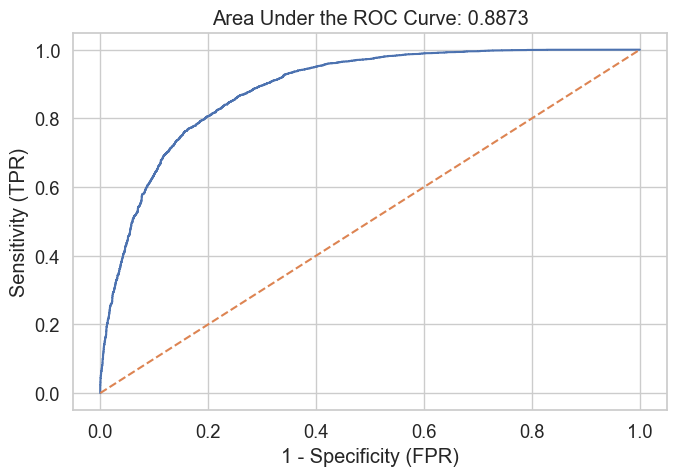

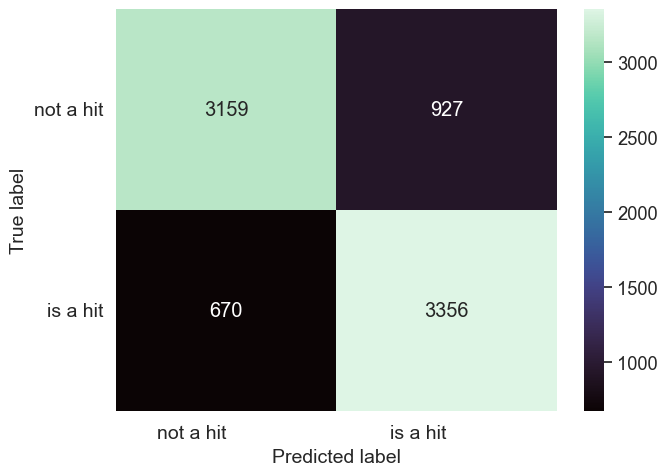

(      y_pred_prob
 0        0.307794
 1        0.761277
 2        0.677121
 3        0.040985
 4        0.762844
 ...           ...
 8107     0.588863
 8108     0.035316
 8109     0.812973
 8110     0.023362
 8111     0.844060
 
 [8112 rows x 1 columns],
       y_pred
 0          0
 1          1
 2          1
 3          0
 4          1
 ...      ...
 8107       1
 8108       0
 8109       1
 8110       0
 8111       1
 
 [8112 rows x 1 columns])

In [13]:
xgb2=GradientBoostingClassifier(                   
                   max_depth=3, 
                   max_features=4,
                   max_leaf_nodes=None,                   
                   #min_samples_leaf=10,
                   n_estimators=100,
                   learning_rate=0.1)
xgb2b = xgb2.fit(X2_train,y2_train)

grad_ypred = xgb2.predict(X2_test)

grad_yproba = xgb2.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)
plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)

In [14]:
import pickle
# plot_model(xgb2, X3_train, y2_train, X3_test, y2_test)
# plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)
pickle.dump(xgb2, open('xgb_model_genre.pkl', 'wb'))